In [1]:
# Importing standard Qiskit libraries:
import numpy as np     
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute, assemble
from qiskit.quantum_info import Statevector
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit import QuantumRegister
from qiskit import ClassicalRegister
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s):
provider = IBMQ.load_account()


/tmp/ipykernel_80/3933405025.py:13: DeprecationWarning: The qiskit.IBMQ entrypoint and the qiskit-ibmq-provider package (accessible from 'qiskit.providers.ibmq`) are deprecated and will be removed in a future release. Instead you should use the qiskit-ibm-provider package which is accessible from 'qiskit_ibm_provider'. You can install it with 'pip install qiskit_ibm_provider'. Just replace 'qiskit.IBMQ' with 'qiskit_ibm_provider.IBMProvider'
  provider = IBMQ.load_account()


In [2]:
# Number of qubits in the system.
L = 2

In [3]:
def zz_circuit(qubit_0,qubit_1,delta):
    qc_zz = QuantumCircuit(L)
    qc_zz.cx(qubit_0,qubit_1)
    qc_zz.rz(2*delta,qubit_1)
    qc_zz.cx(qubit_0,qubit_1)
    return qc_zz

In [4]:
def xx_circuit(qubit_0,qubit_1,delta):
    qc_xx = QuantumCircuit(L)
    qc_xx.h(qubit_0)
    qc_xx.h(qubit_1)
    qc_xx.cx(qubit_0,qubit_1)
    qc_xx.rz(2*delta,qubit_1)
    qc_xx.cx(qubit_0,qubit_1)
    qc_xx.h(qubit_0)
    qc_xx.h(qubit_1)
    return qc_xx

In [5]:
def yy_circuit(qubit_0,qubit_1,delta):
    qc_yy = QuantumCircuit(L)
    qc_yy.sdg(qubit_0)
    qc_yy.sdg(qubit_1)
    qc_yy.h(qubit_0)
    qc_yy.h(qubit_1)
    qc_yy.cx(qubit_0,qubit_1)
    qc_yy.rz(2*delta,qubit_1)
    qc_yy.cx(qubit_0,qubit_1)
    qc_yy.h(qubit_0)
    qc_yy.h(qubit_1)
    qc_yy.s(qubit_0)
    qc_yy.s(qubit_1)
    return qc_yy

In [6]:
r"""
The following function constructs the quantum circuit for one time step for the complete Hamiltonian.
"""
def one_time_step(time_step):
    
    qr = QuantumRegister(L,"q")
    
    # Create the ancilla register
    #anc = QuantumRegister(1,"ancilla")
    
    # Create the quantum circuit
    qc = QuantumCircuit(qr)
    
    # Odd bonds are constructed.
    for i in range(0,L-1,2):
        qc = qc.compose(xx_circuit(i,i+1,time_step))
    
    qc.barrier()
    for i in range(0,L-1,2):
        qc = qc.compose(yy_circuit(i,i+1,time_step))   
        
    qc.barrier()
    for i in range(0,L-1,2):
        qc = qc.compose(zz_circuit(i,i+1,time_step))  
        
    qc.barrier()
    # Even bonds are constructed.
    for i in range(1,L-1,2):
        qc = qc.compose(xx_circuit(i,i+1,time_step))  
    
    qc.barrier()
    for i in range(1,L-1,2):
        qc = qc.compose(yy_circuit(i,i+1,time_step)) 
        
    qc.barrier()
    for i in range(1,L-1,2):
        qc = qc.compose(zz_circuit(i,i+1,time_step))    
    return qc#.draw("mpl",scale=1.5)
    
    
    
#one_time_step(1.e-5).draw("mpl",scale=1.5)

In [7]:
def complete_time_evolution_circuit(time_step,duration):
    steps = int(duration/time_step)
    qr = QuantumRegister(L,"q")
    
    # Create the ancilla register
    #anc = QuantumRegister(1,"ancilla")
    
    # Create a classical register for classical bits
    classical_register = ClassicalRegister(2,"c")
    # Create the quantum circuit
    qc = QuantumCircuit(qr, classical_register)
    qc.initialize([0,1],0)
    qc.initialize([1,0],1)
    for i in range(steps):
        qc = qc.compose(one_time_step(time_step))
    #qc.h(1)
    qc.measure(0,0)
    qc.measure(1,1)
    return qc
J = 1
delta_t = J/100
#complete_time_evolution_circuit(delta_t,1).draw("mpl",scale=1.5)

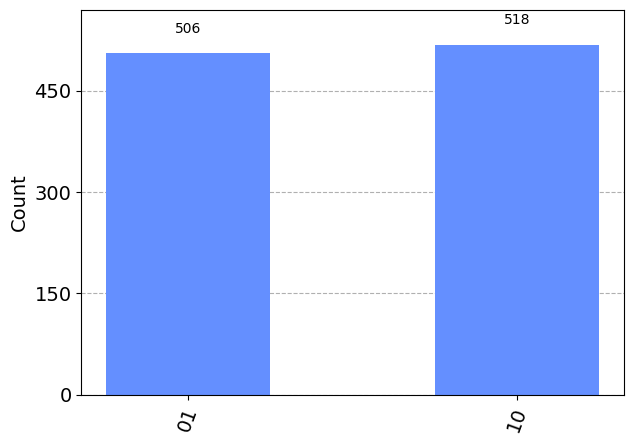

In [8]:
QC = complete_time_evolution_circuit(delta_t,4*J/10)
# Simulating the Circuit:
backend = Aer.get_backend('qasm_simulator')
job = execute(QC, backend, shots = 1024)
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

In [9]:

# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2023-07-19 04:30:27,751: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmq_belem


In [10]:
import time
start = time.time()

In [ ]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_circuit = transpile(QC, device, optimization_level=1)
job = device.run(transpiled_circuit)
job_monitor(job, interval=1)

Job Status: job is queued (None)

In [ ]:
time_taken = time.time()-start
print("Time taken = ",time_taken/60,"minutes")

In [ ]:
# Getting the results from the computation:
results = job.result()
answer = results.get_counts(transpiled_circuit)
plot_histogram(answer)

In [ ]:
answer